## How cyREST works?

![](http://cl.ly/YTR0/rest2.png)

Basic mechanism of cyREST is very simple.  It accesses __resources__ in Cytoscape with standard HTTP verbs: POST, GET, PUT, and DELETE.  The URL above means _"give me status of cyREST server."_

And once you store the return values in Python object, you can access them through standard Python code:

## Create networks from public web services

![](http://upload.wikimedia.org/wikipedia/en/8/80/KEGG_database_logo.gif)

There are many public data sources and web services for biology.  If the service supports Cytoscape-readable file formats, you can directly specify the query URL as the network resource location.  For example, the following URL calls [KEGG REST API](http://www.kegg.jp/kegg/docs/keggapi.html) and load the [TCA Cycle pathway diagram for human](http://www.genome.jp/kegg-bin/show_pathway?org_name=hsa&mapno=00020&mapscale=&show_description=show).

* [KEGG PATHWAY: hsa00020 Citrate cycle (TCA cycle) - Homo sapiens (human)](http://www.genome.jp/dbget-bin/www_bget?pathway+hsa00020)
    * REST API to download the pathway in KGML format: http://rest.kegg.jp/get/hsa00020/kgml

__Hand-drawn pathway diagram in KEGG:__
![](http://www.genome.jp/kegg/pathway/hsa/hsa00020.png)

----
### Warning: You need to install [KEGGScape App](http://apps.cytoscape.org/apps/keggscape) to Cytoscape before running the following cells!
You can just click the link above and press __Install__ to directly install the app from the web.

----

#### Loading external data directly from API
If the data format is supported in Cytoscape, you can import it programmatically by passing the resource location (URL) to Cytoscape:

In [1]:
from py2cytoscape.data.cyrest_client import CyRestClient

In [3]:
# Resource location as URL
tca_cycle_human = 'http://rest.kegg.jp/get/hsa00020/kgml'

# Pass it to Cytoscape
cy = CyRestClient()
tca_human = cy.network.create_from(tca_cycle_human)

and now your Cytoscape window should look like this:

![](http://cl.ly/afuZ/tca_cytoscape.png)


### Connect multiple web services
OK, this is not so interesting because it can be done manually from GUI if we want.  But what happens if you need to check hundreds of resources and filter the results?  You can easily handle such problems if you know how to write your workflow as notebook (code).

In this example, we will do the following:

* Send simple query to fild list of pathways involving cancer (use [TogoWS](http://togows.dbcls.jp/))
* Convert the result tomake it readable for other web service (KEGG API)
* Import some of the result into Cytoscape

In [10]:
# Find pathways involving cancer
res = requests.get('http://togows.org/search/kegg-pathway/cancer/1,50.json')
pp(res.json())

[
    "path:map05200\tPathways in cancer",
    "path:map05202\tTranscriptional misregulation in cancer",
    "path:map05205\tProteoglycans in cancer",
    "path:map05206\tMicroRNAs in cancer",
    "path:map05210\tColorectal cancer",
    "path:map05212\tPancreatic cancer",
    "path:map05213\tEndometrial cancer",
    "path:map05215\tProstate cancer",
    "path:map05216\tThyroid cancer",
    "path:map05219\tBladder cancer",
    "path:map05222\tSmall cell lung cancer",
    "path:map05223\tNon-small cell lung cancer",
    "path:map05230\tCentral carbon metabolism in cancer",
    "path:map05231\tCholine metabolism in cancer"
]


This raw result needs some work to make it usable in other services.  In the following cell, Python creates URLs from the list of pathway ID/pathway name pair:

In [11]:
# Convert to URLs.  This can be done with for loop, but for simplicity, we use map function.

# Extract ID portion of entries
path_ids = list(map(lambda x: x.split('\t')[0], res.json()))

# Make it consumable by KEGG API (Convert to list of URLs)
path_url_human = list(map(lambda x: 'http://rest.kegg.jp/get/' + x.replace('path:map', 'hsa') + '/kgml', path_ids))

pp(path_url_human)

[
    "http://rest.kegg.jp/get/hsa05200/kgml",
    "http://rest.kegg.jp/get/hsa05202/kgml",
    "http://rest.kegg.jp/get/hsa05205/kgml",
    "http://rest.kegg.jp/get/hsa05206/kgml",
    "http://rest.kegg.jp/get/hsa05210/kgml",
    "http://rest.kegg.jp/get/hsa05212/kgml",
    "http://rest.kegg.jp/get/hsa05213/kgml",
    "http://rest.kegg.jp/get/hsa05215/kgml",
    "http://rest.kegg.jp/get/hsa05216/kgml",
    "http://rest.kegg.jp/get/hsa05219/kgml",
    "http://rest.kegg.jp/get/hsa05222/kgml",
    "http://rest.kegg.jp/get/hsa05223/kgml",
    "http://rest.kegg.jp/get/hsa05230/kgml",
    "http://rest.kegg.jp/get/hsa05231/kgml"
]


#### Let's pick first 3 result and import actual pathways.

In [12]:
# This may take a while...
pp(create_from_list(path_url_human[0:3], 'KEGG Metabolic Pathways'))

[
    {
        "networkSUID": [
            26142
        ],
        "source": "http://rest.kegg.jp/get/hsa05205/kgml"
    },
    {
        "networkSUID": [
            25694
        ],
        "source": "http://rest.kegg.jp/get/hsa05202/kgml"
    },
    {
        "networkSUID": [
            24511
        ],
        "source": "http://rest.kegg.jp/get/hsa05200/kgml"
    }
]


#### Discussion
The pipeline above is just a toy example, but you can automate your data preparation and import part if you use Python.  You can try other web services to make it more realistic. 

## Understand REST Principles
We used modern best practices to design cyREST API.  All __HTTP verbs__ are mapped to Cytoscape resources: 

| HTTP Verb | Description |
|:----------:|:------------|
| GET | Retrieving resources (in most cases, it is Cytoscape data objects, such as networks or tables) |
| POST | Creating resources | 
| PUT | Changing/replacing resources or collections |
| DELETE | Deleting resources |

This design style is called [Resource Oriented Architecture (ROA)](http://www.infoq.com/articles/roa-rest-of-rest).

Actually, basic idea is very simple: mapping all operations to existing HTTP verbs.  It is easy to understand once you try actual examples.

#### GET (Get a resource)

In [13]:
# Get a list of network IDs
get_all_networks_url = BASE + 'networks'
print(get_all_networks_url)
res = requests.get(get_all_networks_url)
pp(res.json())

http://137.110.137.158:1234/v1/networks
[
    21958,
    24231,
    23066,
    25694,
    26142,
    24511
]


In [14]:
# Pick the first network from the list above:
network_suid = res.json()[0]
get_network_url = BASE + 'networks/' + str(network_suid)
print(get_network_url)

# Get number of nodes in the network
get_nodes_count_url = BASE + 'networks/' + str(network_suid) + '/nodes/count'
print(get_nodes_count_url)

# Get all nodes
get_nodes_url = BASE + 'networks/' + str(network_suid) + '/nodes'
print(get_nodes_url)

# Get Node data table as CSV
get_node_table_url = BASE + 'networks/' + str(network_suid) + '/tables/defaultnode.csv'
print(get_node_table_url)

http://137.110.137.158:1234/v1/networks/21958
http://137.110.137.158:1234/v1/networks/21958/nodes/count
http://137.110.137.158:1234/v1/networks/21958/nodes
http://137.110.137.158:1234/v1/networks/21958/tables/defaultnode.csv


# Exercise 1: _Guess_ URLs
If a system's RESTful API is well-designed based on ROA best practices, it should be easy to guess similar functions as URLs.

__Display a clickable URLs for the following functions:__

1. Show number of networks in current session
1. Show all edges in a network
1. Show full information for a node (can be any node)
1. Show information for all columns in the default node table
1. Show all values in default node table under "name" column

In [15]:
# Write your answers here...

#### POST (Create a new resource)
To create new resource (objects), you should use __POST__ methods.  URLs follow ROA standards, but you need to read API documents to understand data format for each object.

In [16]:
# Add a new nodes to existing network (with time stamps)
import datetime

new_nodes =[
    'Node created at ' + str(datetime.datetime.now()),
    'Node created at ' + str(datetime.datetime.now())
]

res = requests.post(get_nodes_url, data=json.dumps(new_nodes), headers=HEADERS)
new_node_ids = res.json()
pp(new_node_ids)

[
    {
        "SUID": 27043,
        "name": "Node created at 2015-04-15 20:40:33.608301"
    },
    {
        "SUID": 27044,
        "name": "Node created at 2015-04-15 20:40:33.608346"
    }
]


####  DELETE (Delete a resource)

In [17]:
# Delete all nodes
requests.delete(BASE + 'networks/' + str(sample_network_suids[0]) + '/nodes')

<Response [200]>

In [18]:
# Delete a network
requests.delete(BASE + 'networks/' + str(sample_network_suids[0]))

<Response [200]>

#### PUT (Update a resource)
__PUT__ method is used to update information for existing resources.  Just like POST methods, you need to know the data format to be posted.

In [19]:
# Update a node name
new_values = [
    {
        'SUID': new_node_ids[0]['SUID'],
        'value' : 'updated 1'
    },
    {
        'SUID': new_node_ids[1]['SUID'],
        'value' : 'updated 2'
    }
]
requests.put(BASE + 'networks/' + str(network_suid) + '/tables/defaultnode/columns/name', data=json.dumps(new_values), headers=HEADERS)

<Response [200]>

### 3.3 Create networks from Python objects
And this is the most powerful feature in Cytoscape REST API.  __You can easily convert Python objects into Cytoscape networks, tables, or Visual Styles__

#### How does this work?
Cytoscape REST API sends and receives data as JSON.  For networks, it uses [Cytoscape.js style JSON](http://cytoscape.github.io/cytoscape.js/) (support for more file formats are comming!).  You can programmatically generates networks by converting Python dictionary into JSON.

#### 3.3.1 Prepare Network as Cytoscape.js JSON
Let's start with the simplest network JSON:

In [20]:
# Manually generates JSON as a Python dictionary
def create_network():
    network = { 
            'data': {
                'name': 'I\'m empty!'
            },
            'elements': {
                'nodes':[],
                'edges':[]
            }
    }
    return network


# Difine a simple utility function
def postNetwork(data):
    url_params = {
        'collection': 'My Network Colleciton'
    }
    res = requests.post(BASE + 'networks', params=url_params, data=json.dumps(data), headers=HEADERS)
    return res.json()['networkSUID']


# POST data to Cytoscape
empty_net_1 = create_network()
empty_net_1_suid = postNetwork(empty_net_1)
print('Empty network has SUID ' + str(empty_net_1_suid))

Empty network has SUID 27063


### Modify network dara programmatically
Since it's a simple Python dictionary, it is easy to add data to the network.  Let's add some nodes and edges:

In [21]:
# Create sequence of letters (A-Z)
seq_letters = list(map(chr, range(ord('A'), ord('Z')+1)))
print(seq_letters)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [22]:
# Option 1: Add nods and edges with for loops
def add_nodes_edges(network):
    nodes = []
    edges = []
    
    for lt in seq_letters:
        node = {
            'data': {
                'id': lt
            }
        }
        nodes.append(node)
    for lt in seq_letters:
        edge = {
            'data': { 
                'source': lt, 
                'target': 'A' 
            }
        }
        edges.append(edge)
    network['elements']['nodes'] = nodes
    network['elements']['edges'] = edges
    network['data']['name'] = 'A is the hub.'

# Option 2: Add nodes and edges in functional way
def add_nodes_edges_functional(network):
    network['elements']['nodes'] =  list(map(lambda x: {'data': { 'id': x }}, seq_letters))
    network['elements']['edges'] =  list(map(lambda x: {'data': { 'source': x, 'target': 'A' }}, seq_letters))
    network['data']['name'] = 'A is the hub (Functional Way)'

# Uncomment this if you want to see the actual JSON object
# print(json.dumps(empty_network, indent=4))

net1 = create_network()
net2 = create_network()

add_nodes_edges_functional(net1)
add_nodes_edges(net2)

networks = [net1, net2]

def visualize(net):
    suid = postNetwork(net)
    net['data']['SUID'] = suid
    # Apply layout and Visual Style
    requests.get(BASE + 'apply/layouts/force-directed/' + str(suid))
    requests.get(BASE + 'apply/styles/Directed/' + str(suid))

for net in networks:
    visualize(net)

Now, your Cytoscpae window should look like this:

![](http://cl.ly/aK8w/cy_desktop.png)

### Embed images in IPython Notebook
cyRest has function to generate PNG image directly from current network view.  Let's try to see the result in this notebook.

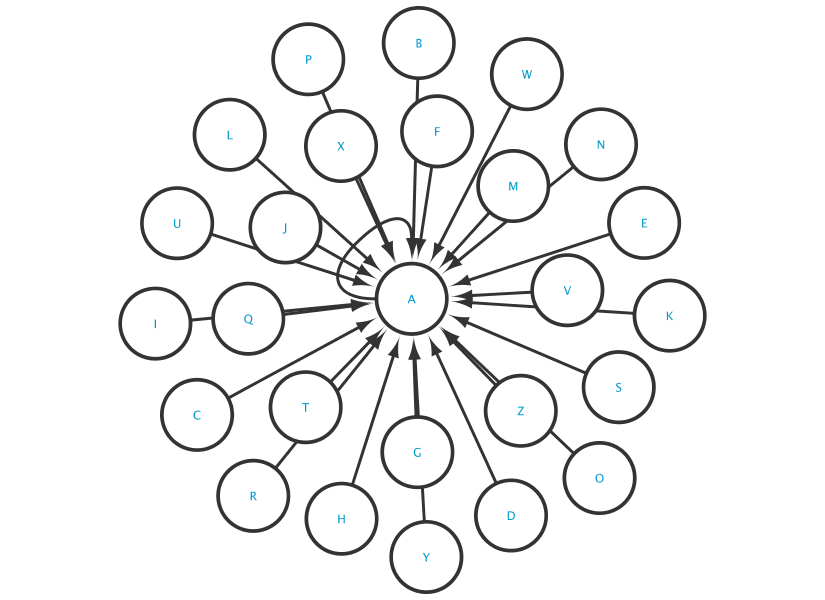

In [23]:
from IPython.display import Image

Image(url=BASE+'networks/' + str(net1['data']['SUID'])+ '/views/first.png', embed=True)

## Introduction to Cytoscape Data Model
Essentially, writing your workflow as a notebook is a programming.  To control Cytoscape efficiently from Notebooks, you need to understand basic data model of Cytoscape.  Let me explain it as a notebook...

First, let's create a data file to visualize Cytoscape data model

In [24]:
%%writefile data/model.sif
Model parent_of ViewModel_1
Model parent_of ViewModel_2
Model parent_of ViewModel_3
ViewModel_1 parent_of Presentation_A
ViewModel_1 parent_of Presentation_B
ViewModel_2 parent_of Presentation_C
ViewModel_3 parent_of Presentation_D
ViewModel_3 parent_of Presentation_E
ViewModel_3 parent_of Presentation_F

Overwriting data/model.sif


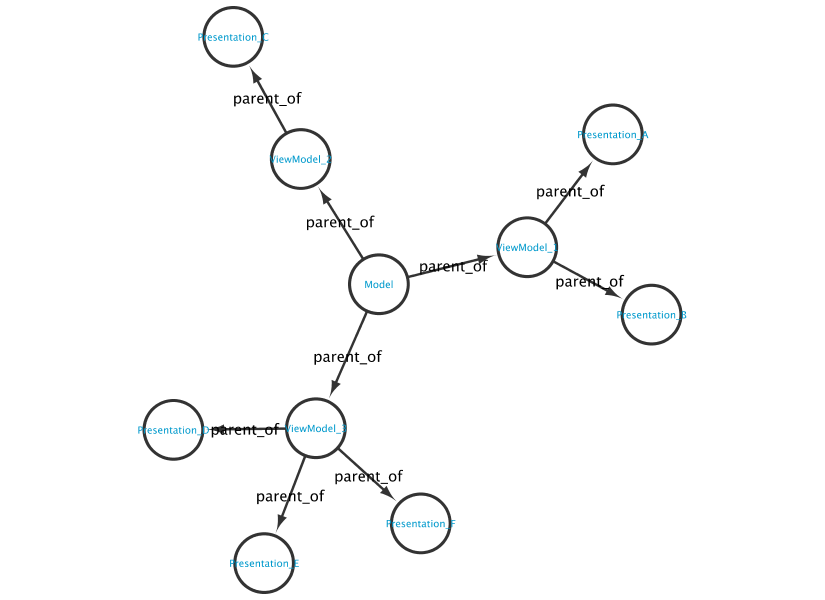

In [25]:
model = [
    'file:////Users/kono/prog/git/sdcsb-advanced-tutorial/tutorials/data/model.sif'
]

# Create!
res = create_from_list(model)
model_suid = res[0]['networkSUID'][0]

requests.get(BASE + 'apply/layouts/force-directed/' + str(model_suid))
Image(url=BASE+'networks/' + str(model_suid)+ '/views/first.png', embed=True)

### Mode, View Model, and Presentation

#### Model
Essentially, __Model__ in Cytoscape means networks and tables.  Internally, Model can have multiple View Models.

#### View Model
State of the view.

This is why you need to use __views__ instead of view in the API:

```
/v1/networks/SUID/views
```

However, Cytoscape 3.2.x has only one rendering engine for now, and end-users do not have access to this feature.  Until Cytoscape Desktop supports multiple renderers, best practice is just use one view per model.  To access the default view, there is a utility method _first_:

In [26]:
view_url = BASE + 'networks/' + str(model_suid) + '/views/first'
print('You can access (default) network view from this URL: ' + view_url)

You can access (default) network view from this URL: http://137.110.137.158:1234/v1/networks/27307/views/first


#### Presentation
Presentation is a stateless, actual graphics you see in the window.  A View Model can have multiple Presentations.  For now, you can assume there is always one presentation per View Model.

----

### What do you need to know as a cyREST user?
CyREST API is fairly low level, and you can access all levels of Cytoscpae data structures.  But if you want to use Cytoscape as a simple network visualization engine for IPython Notebook, here are some tips:

#### Tip 1:  Always keep SUID when you create any new object
__ALL Cytoscape objects, networks, nodes, egdes, and tables have a session unique ID, called SUID__.  When you create any new data objects in Cytoscape, it returns SUIDs.  You need to keep them as Python data objects (list, dict, amp, etc.) to access them later.

#### Tip 2: Create one view per model
Until Cytoscape Desktop fully support multiple view/presentation feature, keep it simple: one view per model.

#### Tip 3: Minimize number of API calls
Of course, there is a API to add / remove / update one data object per API call, but it is extremely inefficient!

#### 3.3.2 Prepare Network as edgelist
Edgelist is a minimalistic data format for networks and it is widely used in popular libraries including NetworkX and igraph.  Preparing edgelist in Python is straightforward.  You just need to prepare a list of edges as string like:

```
a b
b c
a c
c d
d f
b f
f g
f h
```

In Python, there are many ways to generate string like this.  Here is a naive approach:

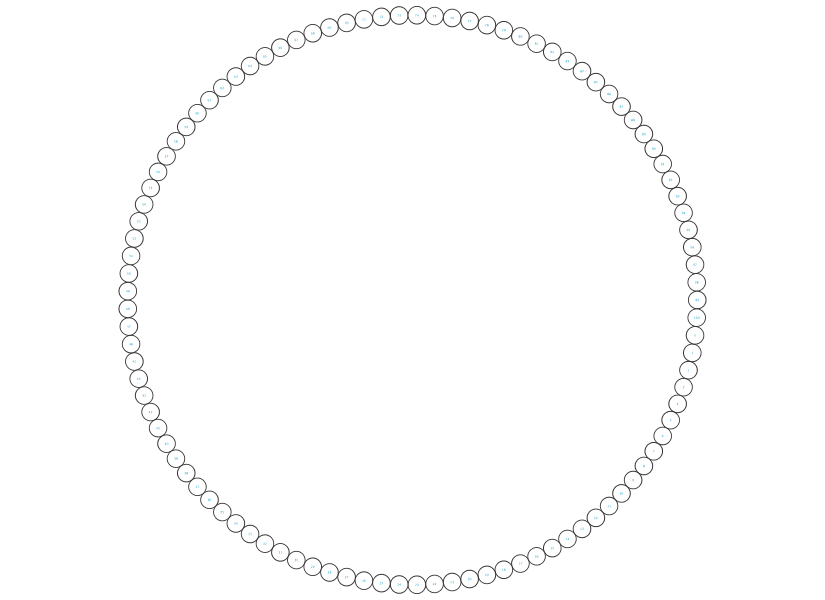

In [29]:
data_str = ''
n = 0
while n <100:
    data_str = data_str + str(n) + '\t' + str(n+1) + '\n'
    n = n + 1

# Join the first and last nodes
data_str = data_str + '100\t0\n'

# print(data_str)

# You can create multiple networks by running simple for loop:
for i in range(3):
    res = requests.post(BASE + 'networks?format=edgelist&collection=Rings!', data=data_str, headers=HEADERS)
    circle_suid = res.json()['networkSUID']
    requests.get(BASE + 'apply/layouts/circular/' + str(circle_suid))

Image(url=BASE+'networks/' + str(circle_suid) + '/views/first.png', embed=True)

# Exercise 2: Create a network from a simple edge list file
Edge list is a human-editable text file to represent a graph structure.  Using the sample data abobe (edge list example in 3.3.2), create a new network in Cytoscape from the edge list and visualize it just like the ring network above.  

__Hint__: Use Magic!

In [28]:
# Write your code here...

## Discussion
In this section, we've learned how to generate networks programmatically in Python.  But for real world problems, it is not a good idea to use low level Python code to generate networks because there are lots of cool graph libraries such as NetworkX or igraph which provide high level graph APIs.  In the next session, let's use them to analyze real network data sets.

## Continues to [Lesson 2: Visualization](Lesson_2_Visualization.ipynb)